<a href="https://colab.research.google.com/github/LeonMichell0526/TecWeb1/blob/main/Te_damos_la_bienvenida_a_Colaboratory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Bibliotecas estándar y de entorno
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
# Transformers (HuggingFace)
from transformers import BertTokenizer, BertForSequenceClassification
import torch.optim as optim  # Usar AdamW desde torch
# Barra de progreso
from tqdm import tqdm
# Validación y métricas
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    auc
)

# ================== PREPROCESAMIENTO Y DIVISIÓN ==================

# Definir el nombre del modelo preentrenado
MODEL_NAME = "dccuchile/bert-base-spanish-wwm-cased"
#MODEL_NAME = "dccuchile/bert-base-spanish-wwm-cased"
# MODEL_NAME = "finiteautomata/beto-sentiment-analysis"

# Crear directorio de salida para guardar archivos
output_dir = "Modelo_BERT"
os.makedirs(output_dir, exist_ok=True)

# Ruta del archivo con el dataset consolidado
file_path = "Dataset_Emociones_Completo.csv"
print(f"Cargando dataset desde: {file_path}")
df = pd.read_csv(file_path, encoding='utf-8')
print(f"Dataset cargado con {df.shape[0]} filas y {df.shape[1]} columnas")

# Crear una copia de la columna original de emociones en texto
# Esto permite conservar el nombre de la emoción aún después del mapeo numérico
df["Emocion_Textual"] = df["Emocion"]

# Codificar emociones en orden alfabético para garantizar consistencia reproducible
etiquetas_ordenadas = sorted(df["Emocion_Textual"].unique())
emocion_labels = {etq: idx for idx, etq in enumerate(etiquetas_ordenadas)}  # {'Alegría':0, 'Ira':1, ...}
reverse_labels = {idx: etq for etq, idx in emocion_labels.items()}  # {0:'Alegría', 1:'Ira', ...}
df["Emocion"] = df["Emocion_Textual"].map(emocion_labels)
NUM_LABELS = len(emocion_labels)

# Guardar el mapeo emoción → índice como archivo JSON para futura referencia
tags_path = os.path.join(output_dir, "emocion_labels.json")
with open(tags_path, "w", encoding="utf-8") as f:
    json.dump(emocion_labels, f, ensure_ascii=False, indent=4)

# Imprimir en consola el mapeo generado y el orden de etiquetas
print("\nMapeo emoción → índice:")
for k, v in emocion_labels.items():
    print(f"{k} → {v}")

print("\nOrden general del vector de emociones:")
for idx in range(NUM_LABELS):
    print(f"{idx} → {reverse_labels[idx]}")

# Dividir el dataset en entrenamiento (80%) y prueba (20%) de manera estratificada
print("\nDividiendo el dataset en entrenamiento (80%) y prueba (20%)...")
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["Texto_Procesado"].tolist(),  # Lista de textos
    df["Emocion"].tolist(),          # Lista de etiquetas codificadas
    test_size=0.2,                   # Porcentaje de prueba
    stratify=df["Emocion"],         # Preservar distribución de clases
    random_state=42                 # Semilla para reproducibilidad
)
print(f"Entrenamiento: {len(train_texts)} muestras | Prueba: {len(test_texts)} muestras")

# Guardar los conjuntos de entrenamiento y prueba en archivos CSV
pd.DataFrame({"Texto_Procesado": train_texts, "Emocion": train_labels}).to_csv(
    os.path.join(output_dir, "Train_Dataset.csv"), index=False, encoding='utf-8'
)
pd.DataFrame({"Texto_Procesado": test_texts, "Emocion": test_labels}).to_csv(
    os.path.join(output_dir, "Test_Dataset.csv"), index=False, encoding='utf-8'
)
print("Archivos CSV de entrenamiento y prueba guardados.")

# Cargar el tokenizador del modelo BERT especificado
print(f"\nCargando tokenizador: {MODEL_NAME}")
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

# Función para tokenizar textos y convertirlos en tensores compatibles con PyTorch
def tokenizar_y_tensorizar(texts, labels):
    encodings = tokenizer(
        texts,
        truncation=True,        # Cortar textos largos
        padding=True,           # Rellenar textos cortos
        max_length=128,         # Longitud máxima
        return_tensors="pt"     # Retornar tensores de PyTorch
    )
    return TensorDataset(encodings["input_ids"], encodings["attention_mask"], torch.tensor(labels))

# Asegurar que los textos sean strings y las etiquetas enteros
train_texts = [str(text) for text in train_texts]
train_labels = [int(label) for label in train_labels]
test_texts = [str(text) for text in test_texts]
test_labels = [int(label) for label in test_labels]

# Aplicar tokenización y conversión a tensores
print("Tokenizando y convirtiendo a tensores...")
train_data = tokenizar_y_tensorizar(train_texts, train_labels)
test_data = tokenizar_y_tensorizar(test_texts, test_labels)

# Definir tamaño de lote
BATCH_SIZE = 16

# Crear DataLoaders para manejo eficiente durante entrenamiento y evaluación
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

print("Preprocesamiento completado. Datos listos para entrenamiento.\n")

Cargando dataset desde: Dataset_Emociones_Completo.csv
Dataset cargado con 4091 filas y 6 columnas

Mapeo emoción → índice:
Disgusto → 0
Felicidad → 1
Ira → 2
Miedo → 3
Sorpresa → 4
Tristeza → 5

Orden general del vector de emociones:
0 → Disgusto
1 → Felicidad
2 → Ira
3 → Miedo
4 → Sorpresa
5 → Tristeza

Dividiendo el dataset en entrenamiento (80%) y prueba (20%)...
Entrenamiento: 3272 muestras | Prueba: 819 muestras
Archivos CSV de entrenamiento y prueba guardados.

Cargando tokenizador: dccuchile/bert-base-spanish-wwm-cased


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/242k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/480k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

Tokenizando y convirtiendo a tensores...
Preprocesamiento completado. Datos listos para entrenamiento.



In [2]:
# ================== ENTRENAMIENTO DEL MODELO ==================

# Cargar etiquetas desde archivo JSON y construir diccionario inverso para interpretar predicciones
tags_path ="emocion_labels.json"
with open(tags_path, "r", encoding="utf-8") as f:
    emocion_labels = json.load(f)
reverse_labels = {int(v): k for k, v in emocion_labels.items()}
NUM_LABELS = len(emocion_labels)  # Total de clases o emociones posibles

# Determinar si se usará GPU o CPU para el entrenamiento
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

# Inicializar el modelo BERT preentrenado con una capa de clasificación para múltiples etiquetas
#MODEL_NAME = "bert-base-multilingual-cased"
MODEL_NAME = "dccuchile/bert-base-spanish-wwm-cased"
#MODEL_NAME = "finiteautomata/beto-sentiment-analysis"

print("Cargando modelo BERT preentrenado...")
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)
model.to(device)  # Enviar modelo a GPU si está disponible

# Cargar el tokenizador correspondiente al modelo BERT
print("Cargando tokenizador BERT...")
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

# Definir la función de pérdida (CrossEntropy para clasificación multiclase) y el optimizador AdamW
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# Cargar los datasets de entrenamiento y prueba desde archivos CSV generados previamente
print("Cargando datasets desde archivos CSV...")
train_df = pd.read_csv(os.path.join(output_dir, "Train_Dataset.csv"), encoding='utf-8')
test_df = pd.read_csv(os.path.join(output_dir, "Test_Dataset.csv"), encoding='utf-8')
print(f"Datos de entrenamiento: {len(train_df)}, Datos de prueba: {len(test_df)}")

# Función auxiliar para tokenizar textos y convertirlos en TensorDataset compatible con PyTorch
def convert_to_tensor_dataset(df):
    textos = df['Texto_Procesado'].fillna("").astype(str).tolist()  # Asegura que todos sean strings
    encodings = tokenizer(
        df['Texto_Procesado'].tolist(),           # Lista de textos preprocesados
        truncation=True,                          # Truncar a la longitud máxima si excede
        padding=True,                             # Agregar padding para igualar longitudes
        max_length=128,                           # Longitud máxima por texto
        return_tensors="pt"                       # Retornar tensores de PyTorch
    )
    labels = torch.tensor(df['Emocion'].values)   # Convertir etiquetas a tensores
    return TensorDataset(encodings['input_ids'], encodings['attention_mask'], labels)

# Aplicar tokenización a los datasets
train_df[train_df['Texto_Procesado'].notnull() & (train_df['Texto_Procesado'].astype(str).str.strip() != '')]
test_data = convert_to_tensor_dataset(test_df)

# Configurar los DataLoaders para entrenamiento y prueba
BATCH_SIZE = 16  # Número de muestras por batch
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)   # Mezclar los datos
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)    # Evaluación sin mezcla

# Establecer número de épocas para el entrenamiento
EPOCHS = 5

# Inicializar listas para registrar métricas por época
epochs_list = []
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

# Función para entrenar el modelo en cada época
def train_model(model, train_dataloader):
    model.train()  # Activar modo de entrenamiento
    total_loss, correct_predictions, total_samples = 0, 0, 0
    for batch in tqdm(train_dataloader, desc="Entrenando", unit="batch", leave=False):
        input_ids, attention_mask, labels = [x.to(device) for x in batch]  # Enviar datos a GPU/CPU
        optimizer.zero_grad()  # Reiniciar gradientes acumulados
        outputs = model(input_ids, attention_mask=attention_mask)  # Forward pass
        loss = loss_function(outputs.logits, labels)  # Calcular pérdida
        total_loss += loss.item()  # Acumular pérdida
        loss.backward()  # Backpropagation
        optimizer.step()  # Actualizar pesos
        preds = torch.argmax(outputs.logits, dim=1)  # Obtener clases predichas
        correct_predictions += torch.sum(preds == labels).item()  # Contar aciertos
        total_samples += labels.size(0)
    return total_loss / len(train_dataloader), correct_predictions / total_samples

# Función para evaluar el modelo sin actualizar pesos
def evaluate_model(model, test_dataloader):
    model.eval()  # Activar modo evaluación
    total_loss, correct_predictions, total_samples = 0, 0, 0
    with torch.no_grad():  # Desactivar cálculo de gradientes
        for batch in tqdm(test_dataloader, desc="Evaluando", unit="batch", leave=False):
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = loss_function(outputs.logits, labels)
            total_loss += loss.item()
            preds = torch.argmax(outputs.logits, dim=1)
            correct_predictions += torch.sum(preds == labels).item()
            total_samples += labels.size(0)
    return total_loss / len(test_dataloader), correct_predictions / total_samples

# Función principal para ejecutar el ciclo completo de entrenamiento y evaluación por época
def run_training():
    for epoch in range(EPOCHS):
        print(f"\n===== Época {epoch+1} de {EPOCHS} =====")
        train_loss, train_acc = train_model(model, train_dataloader)  # Entrenar una época
        test_loss, test_acc = evaluate_model(model, test_dataloader)  # Evaluar el modelo

        # Imprimir métricas de desempeño
        print(f"Entrenamiento - Pérdida: {train_loss:.4f}, Exactitud: {train_acc:.4f}")
        print(f"Prueba       - Pérdida: {test_loss:.4f}, Exactitud: {test_acc:.4f}")

        # Almacenar métricas
        epochs_list.append(epoch+1)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

    # Guardar el modelo entrenado en disco para reutilización
    model_save_path = os.path.join(output_dir, "BERT_Emociones_Model.pth")
    torch.save(model.state_dict(), model_save_path)
    print(f"Modelo entrenado guardado en: {model_save_path}")

# Ejecutar el entrenamiento completo
d = run_training()

Usando dispositivo: cuda
Cargando modelo BERT preentrenado...


pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Cargando tokenizador BERT...
Cargando datasets desde archivos CSV...
Datos de entrenamiento: 3272, Datos de prueba: 819

===== Época 1 de 5 =====


Entrenando:   0%|          | 0/205 [00:00<?, ?batch/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Entrenamiento - Pérdida: 1.2325, Exactitud: 0.5092
Prueba       - Pérdida: 0.9155, Exactitud: 0.6581

===== Época 2 de 5 =====


Entrenamiento - Pérdida: 0.6927, Exactitud: 0.7476
Prueba       - Pérdida: 0.9000, Exactitud: 0.6654

===== Época 3 de 5 =====


Entrenamiento - Pérdida: 0.4108, Exactitud: 0.8573
Prueba       - Pérdida: 0.9656, Exactitud: 0.6667

===== Época 4 de 5 =====


Entrenamiento - Pérdida: 0.2413, Exactitud: 0.9172
Prueba       - Pérdida: 1.0460, Exactitud: 0.6838

===== Época 5 de 5 =====


Entrenamiento - Pérdida: 0.1734, Exactitud: 0.9444
Prueba       - Pérdida: 1.2297, Exactitud: 0.6630
Modelo entrenado guardado en: Modelo_BERT/BERT_Emociones_Model.pth


In [ ]:
from google.colab import files
files.download("/content/Modelo_BERT/BERT_Emociones_Model.pth")

Cargando modelo BERT preentrenado...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-cased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Cargando tokenizador...
Cargando modelo entrenado desde Modelo_BERT/BERT_Emociones_Model.pth...
Modelo cargado y listo para predicciones.


Evaluando: 100%|██████████| 52/52 [00:05<00:00,  8.70batch/s]



===== Métricas de Evaluación =====
Exactitud (Accuracy): 0.6630
Precisión (Macro): 0.6644
Recall (Macro): 0.6630
F1-Score (Macro): 0.6566
Área bajo la curva ROC-AUC: 0.9137

Métricas guardadas en: Modelo_BERT/metricas_evaluacion.txt


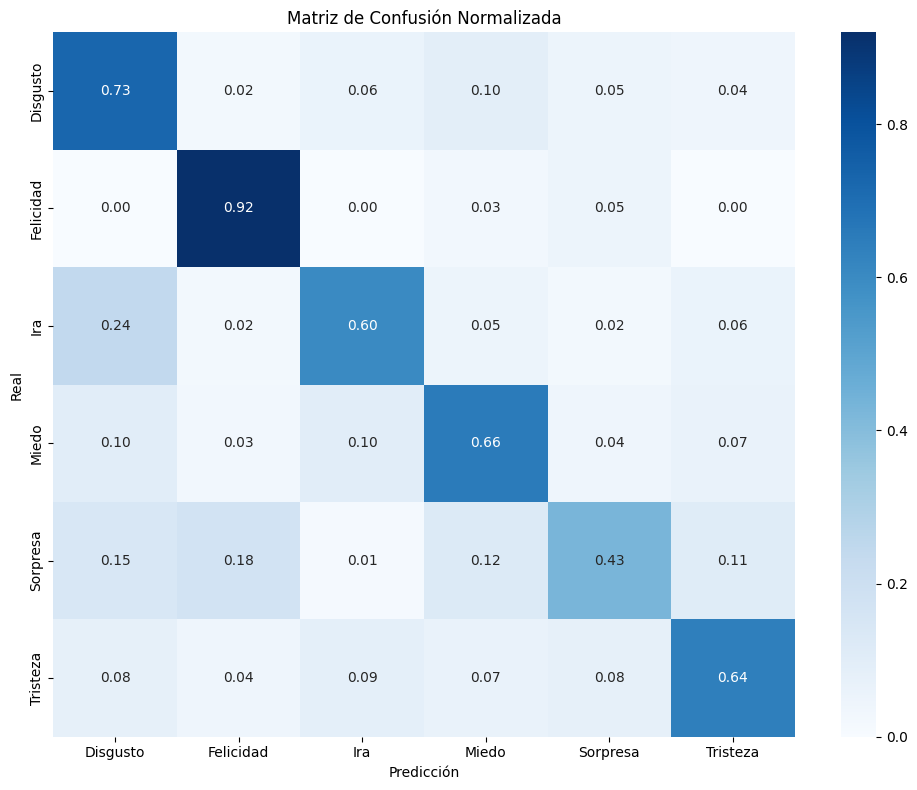

Matriz de confusión guardada en: Modelo_BERT/matriz_confusion.png


In [3]:
# ================== EVALUACIÓN DEL MODELO ==================

# Cargar etiquetas y diccionario reverse_labels generados en entrenamiento
etiquetas_path = os.path.join(output_dir, "emocion_labels.json")
with open(etiquetas_path, "r", encoding="utf-8") as f:
    emocion_labels = json.load(f)  # Cargar diccionario de etiquetas
reverse_labels = {int(v): k for k, v in emocion_labels.items()}  # Invertir el diccionario para mapear índices a emociones
NUM_LABELS = len(emocion_labels)

# Determinar si se dispone de GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargar modelo BERT con una capa de clasificación ajustada
#MODEL_NAME = "bert-base-multilingual-cased"
MODEL_NAME = "dccuchile/bert-base-spanish-wwm-cased"
#MODEL_NAME = "finiteautomata/beto-sentiment-analysis"

print("Cargando modelo BERT preentrenado...")
model = BertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=NUM_LABELS)
model.to(device)  # Enviar modelo a GPU o CPU

# Cargar tokenizador correspondiente
print("Cargando tokenizador...")
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

# Cargar pesos entrenados del modelo
modelo_path = os.path.join(output_dir, "BERT_Emociones_Model.pth")
print(f"Cargando modelo entrenado desde {modelo_path}...")
model.load_state_dict(torch.load(modelo_path, map_location=device))  # Cargar pesos entrenados
model.eval()  # Modo evaluación (desactiva dropout)
print("Modelo cargado y listo para predicciones.")

# Cargar datasets para evaluación
train_df = pd.read_csv("/content/Modelo_BERT/Train_Dataset.csv", encoding='utf-8')
test_df = pd.read_csv("/content/Modelo_BERT/Test_Dataset.csv", encoding='utf-8')

# Función auxiliar para convertir DataFrame en TensorDataset
def convert_to_tensor_dataset(df):
    # Asegurarse de que los textos sean strings y eliminar nulos
    textos = df['Texto_Procesado'].fillna("").astype(str).tolist()

    encodings = tokenizer(
        textos,
        truncation=True,
        padding=True,
        max_length=128,
        return_tensors="pt"
    )
    labels = torch.tensor(df['Emocion'].values)
    return TensorDataset(encodings['input_ids'], encodings['attention_mask'], labels)

# Crear DataLoaders
BATCH_SIZE = 16
train_data = convert_to_tensor_dataset(train_df)
test_data = convert_to_tensor_dataset(test_df)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

# Función para predecir la emoción de un solo texto
def predecir_emocion(texto):
    model.eval()
    inputs = tokenizer(texto, truncation=True, padding=True, max_length=128, return_tensors="pt").to(device)
    with torch.no_grad():  # Desactiva el cálculo de gradientes
        outputs = model(**inputs)
        logits = outputs.logits
        pred_label = int(torch.argmax(logits, dim=1).item())  # Obtener clase con mayor probabilidad
    return reverse_labels.get(pred_label, f"Desconocido ({pred_label})")

# Función principal de evaluación
def evaluar_modelo(test_dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc="Evaluando", unit="batch"):
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            outputs = model(input_ids, attention_mask=attention_mask)
            probs = torch.softmax(outputs.logits, dim=1).cpu().numpy()  # Convertir logits a probabilidades
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()  # Obtener predicciones
            labels = labels.cpu().numpy()

            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(labels)

    # Calcular métricas
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='macro')
    auc_score = roc_auc_score(all_labels, all_probs, multi_class='ovr')

    # Imprimir en consola
    print("\n===== Métricas de Evaluación =====")
    print(f"Exactitud (Accuracy): {accuracy:.4f}")
    print(f"Precisión (Macro): {precision:.4f}")
    print(f"Recall (Macro): {recall:.4f}")
    print(f"F1-Score (Macro): {f1:.4f}")
    print(f"Área bajo la curva ROC-AUC: {auc_score:.4f}\n")

    # Guardar métricas en archivo
    resultados_path = os.path.join(output_dir, "metricas_evaluacion.txt")
    with open(resultados_path, "w", encoding='utf-8') as f:
        f.write("===== Métricas de Evaluación =====\n")
        f.write(f"Exactitud (Accuracy): {accuracy:.4f}\n")
        f.write(f"Precisión (Macro): {precision:.4f}\n")
        f.write(f"Recall (Macro): {recall:.4f}\n")
        f.write(f"F1-Score (Macro): {f1:.4f}\n")
        f.write(f"Área bajo la curva ROC-AUC: {auc_score:.4f}\n")
    print(f"Métricas guardadas en: {resultados_path}")

    # Matriz de confusión normalizada
    cm = confusion_matrix(all_labels, all_preds, normalize='true')
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt='.2f',
        cmap='Blues',
        xticklabels=[reverse_labels[i] for i in range(NUM_LABELS)],
        yticklabels=[reverse_labels[i] for i in range(NUM_LABELS)]
    )
    plt.xlabel("Predicción")
    plt.ylabel("Real")
    plt.title("Matriz de Confusión Normalizada")
    plt.tight_layout()
    cm_path = os.path.join(output_dir, "matriz_confusion.png")
    plt.savefig(cm_path, dpi=300)  # Alta resolución
    plt.show()  # Mostrar la matriz en pantalla
    plt.close()
    print(f"Matriz de confusión guardada en: {cm_path}")

# Ejecutar evaluación si se ejecuta directamente
if __name__ == "__main__":
    evaluar_modelo(test_dataloader)
